# NIHCXR Clinical Drift Experiments Tutorial

## Import Libraries and Load NIHCXR Dataset

In [1]:
"""NIHCXR Clinical Drift Experiments Tutorial."""


import numpy as np
from monai.transforms import Compose, Lambdad, Resized
from torchxrayvision.models import DenseNet

from cyclops.data.loader import load_nihcxr
from cyclops.data.slicer import SliceSpec
from cyclops.monitor import ClinicalShiftApplicator, Detector, Reductor, TSTester
from cyclops.monitor.plotter import plot_drift_experiment, plot_drift_timeseries


nih_ds = load_nihcxr("/mnt/data/clinical_datasets/NIHCXR")["test"]

/home/amritk/.cache/pypoetry/virtualenvs/pycyclops-mhx6UJW0-py3.9/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Example 1. Generate Source/Target Dataset for Experiments (1-2)

In [2]:
shifter = ClinicalShiftApplicator(
    "sex",
    source=None,
    target="F",
    shift_id="Patient Gender",
)
source_ds, target_ds = shifter.apply_shift(nih_ds, num_proc=6)

transforms = Compose(
    [
        Resized(
            keys=("image",),
            spatial_size=(224, 224),
            allow_missing_keys=True,
        ),
        Lambdad(
            keys=("image",),
            func=lambda x: ((2 * (x / 255.0)) - 1.0) * 1024,
            allow_missing_keys=True,
        ),
        Lambdad(
            ("image",),
            func=lambda x: np.mean(x, axis=0)[np.newaxis, :] if x.shape[0] != 1 else x,
        ),
    ],
)

Filter (num_proc=6):   0%|          | 0/25596 [00:00<?, ? examples/s]

Filter (num_proc=6):  17%|█▋        | 4266/25596 [00:00<00:00, 33866.90 examples/s]

Filter (num_proc=6):  83%|████████▎ | 21330/25596 [00:00<00:00, 88514.67 examples/s]

Filter (num_proc=6): 100%|██████████| 25596/25596 [00:00<00:00, 67311.63 examples/s]

## Example 2. Sensitivity test experiment with 3 dimensionality reduction techniques


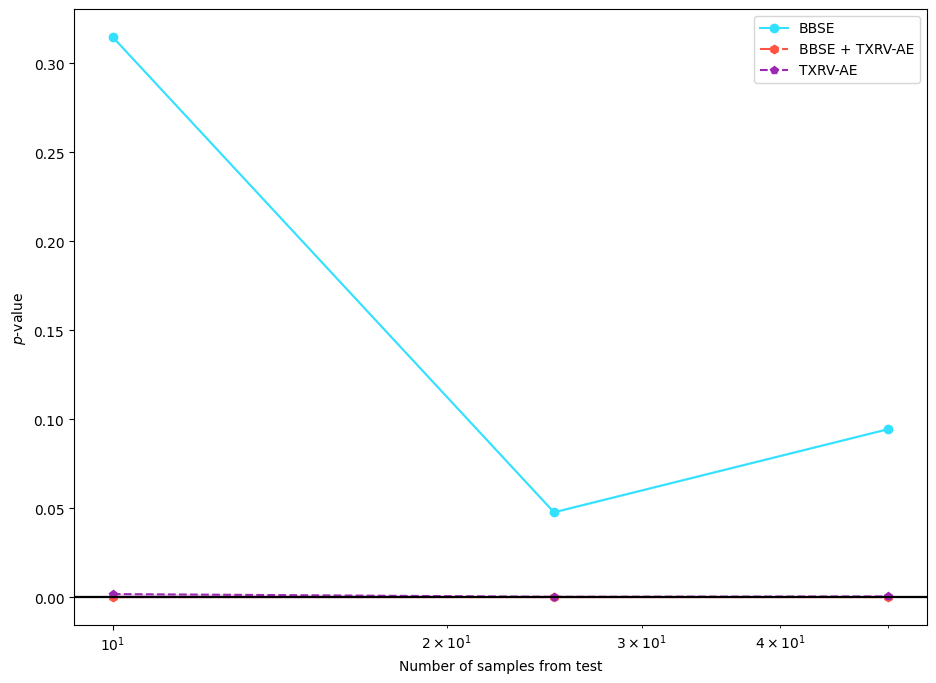

In [3]:
model = DenseNet(weights="densenet121-res224-all")
dr_methods = {
    "BBSE": "bbse-soft",
    "BBSE + TXRV-AE": "bbse-soft+txrv-ae",
    "TXRV-AE": "txrv-ae",
}
results = {}

for name, dr_method in dr_methods.items():
    if name == "TXRV-AE":
        reductor = Reductor(
            dr_method=dr_method,
            transforms=transforms,
            feature_columns=["image"],
        )
    else:
        reductor = Reductor(
            dr_method=dr_method,
            model=model,
            transforms=transforms,
            feature_columns=["image"],
        )
    detector = Detector(
        "sensitivity_test",
        reductor=reductor,
        tester=TSTester(tester_method="ks"),
        source_sample_size=50,
        target_sample_size=[10, 25, 50],
        num_runs=1,
    )
    result = detector.detect_shift(source_ds, target_ds)
    results[name] = result
plot_drift_experiment(results)

## Example 3. Sensitivity test experiment with models trained on different datasets

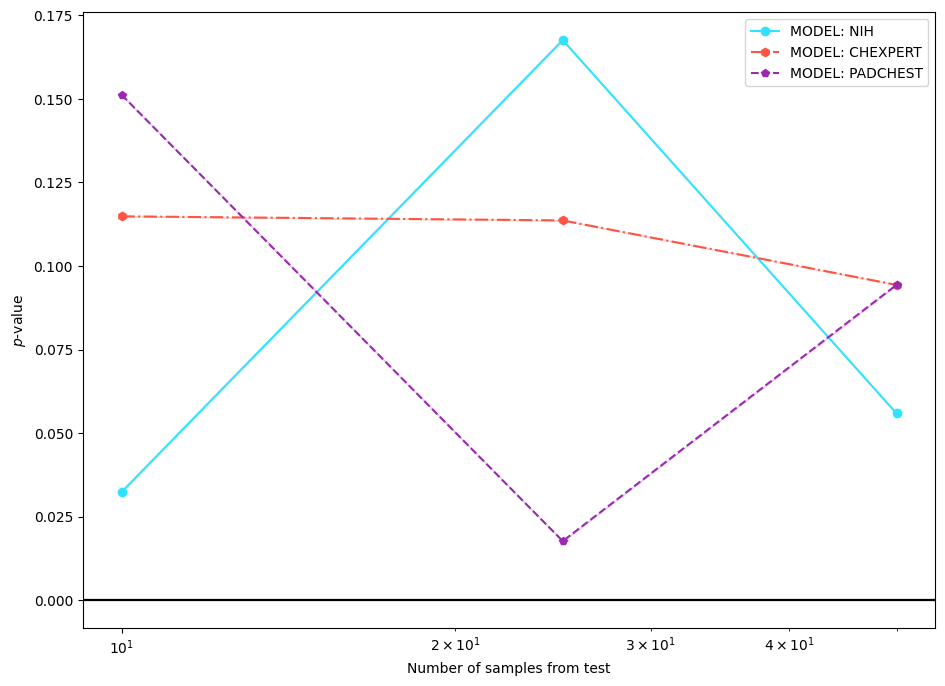

In [4]:
models = {
    "MODEL: NIH": "densenet121-res224-nih",
    "MODEL: CHEXPERT": "densenet121-res224-chex",
    "MODEL: PADCHEST": "densenet121-res224-pc",
}
results = {}

for model_name, model in models.items():
    detector = Detector(
        "sensitivity_test",
        reductor=Reductor(
            dr_method="bbse-soft",
            model=DenseNet(weights=model),
            transforms=transforms,
            feature_columns=["image"],
        ),
        tester=TSTester(tester_method="ks"),
        source_sample_size=50,
        target_sample_size=[10, 25, 50],
        num_runs=1,
    )
    results[model_name] = detector.detect_shift(source_ds, target_ds)
plot_drift_experiment(results)

## Example 4. Sensitivity test experiment with different clinical shifts

Filter (num_proc=6):   0%|          | 0/25596 [00:00<?, ? examples/s]

Filter (num_proc=6):  17%|█▋        | 4266/25596 [00:00<00:00, 32885.86 examples/s]

Filter (num_proc=6):  50%|█████     | 12798/25596 [00:00<00:00, 60226.40 examples/s]

Filter (num_proc=6): 100%|██████████| 25596/25596 [00:00<00:00, 76067.48 examples/s]

Filter (num_proc=6): 100%|██████████| 25596/25596 [00:00<00:00, 50791.85 examples/s]

Filter (num_proc=6):   0%|          | 0/25596 [00:00<?, ? examples/s]

Filter (num_proc=6):  17%|█▋        | 4266/25596 [00:00<00:00, 31789.60 examples/s]

Filter (num_proc=6):  50%|█████     | 12798/25596 [00:00<00:00, 57330.27 examples/s]

Filter (num_proc=6):  83%|████████▎ | 21330/25596 [00:00<00:00, 65867.94 examples/s]

Filter (num_proc=6): 100%|██████████| 25596/25596 [00:00<00:00, 49247.74 examples/s]

Filter (num_proc=6):   0%|          | 0/25596 [00:00<?, ? examples/s]

Filter (num_proc=6):  17%|█▋        | 4266/25596 [00:00<00:00, 30620.49 examples/s]

Filter (num_proc=6):  50%|█████     | 12798/25596 [00:00<00:00, 51340.50 examples/s]

Filter (num_proc=6):  83%|████████▎ | 21330/25596 [00:00<00:00, 60968.84 examples/s]

Filter (num_proc=6): 100%|██████████| 25596/25596 [00:00<00:00, 44759.52 examples/s]

Filter (num_proc=6):   0%|          | 0/25596 [00:00<?, ? examples/s]

Filter (num_proc=6):  17%|█▋        | 4266/25596 [00:00<00:00, 30416.40 examples/s]

Filter (num_proc=6):  50%|█████     | 12798/25596 [00:00<00:00, 56194.37 examples/s]

Filter (num_proc=6): 100%|██████████| 25596/25596 [00:00<00:00, 73573.79 examples/s]

Filter (num_proc=6): 100%|██████████| 25596/25596 [00:00<00:00, 50134.96 examples/s]

Filter (num_proc=6):   0%|          | 0/25596 [00:00<?, ? examples/s]

Filter (num_proc=6):  17%|█▋        | 4266/25596 [00:00<00:00, 30705.09 examples/s]

Filter (num_proc=6):  50%|█████     | 12798/25596 [00:00<00:00, 51688.20 examples/s]

Filter (num_proc=6):  83%|████████▎ | 21330/25596 [00:00<00:00, 61192.63 examples/s]

Filter (num_proc=6): 100%|██████████| 25596/25596 [00:00<00:00, 46152.58 examples/s]

Filter (num_proc=6):   0%|          | 0/25596 [00:00<?, ? examples/s]

Filter (num_proc=6):  17%|█▋        | 4266/25596 [00:00<00:00, 28207.56 examples/s]

Filter (num_proc=6):  50%|█████     | 12798/25596 [00:00<00:00, 54832.62 examples/s]

Filter (num_proc=6):  83%|████████▎ | 21330/25596 [00:00<00:00, 62902.11 examples/s]

Filter (num_proc=6): 100%|██████████| 25596/25596 [00:00<00:00, 47213.04 examples/s]

Filter (num_proc=6):   0%|          | 0/25596 [00:00<?, ? examples/s]

Filter (num_proc=6):  17%|█▋        | 4266/25596 [00:00<00:00, 29575.29 examples/s]

Filter (num_proc=6):  50%|█████     | 12798/25596 [00:00<00:00, 54485.36 examples/s]

Filter (num_proc=6):  83%|████████▎ | 21330/25596 [00:00<00:00, 61190.33 examples/s]

Filter (num_proc=6): 100%|██████████| 25596/25596 [00:00<00:00, 46946.69 examples/s]

Filter (num_proc=6):   0%|          | 0/25596 [00:00<?, ? examples/s]

Filter (num_proc=6):  17%|█▋        | 4266/25596 [00:00<00:00, 31376.30 examples/s]

Filter (num_proc=6):  50%|█████     | 12798/25596 [00:00<00:00, 57991.21 examples/s]

Filter (num_proc=6):  83%|████████▎ | 21330/25596 [00:00<00:00, 64886.52 examples/s]

Filter (num_proc=6): 100%|██████████| 25596/25596 [00:00<00:00, 46966.92 examples/s]

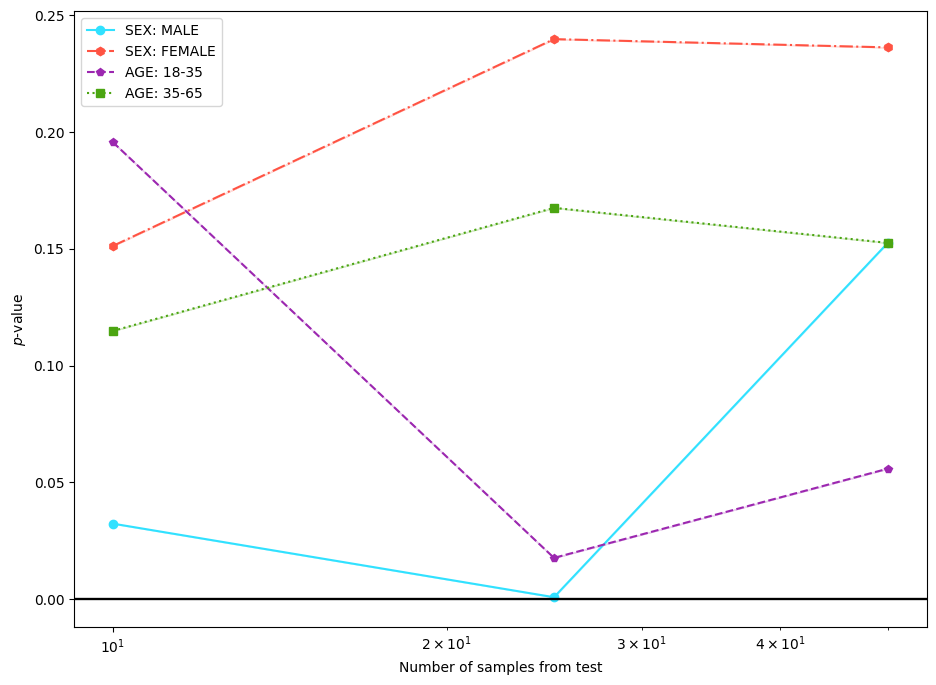

In [5]:
model = DenseNet(weights="densenet121-res224-all")
source_slice = None
target_slices = {
    "SEX: MALE": SliceSpec(spec_list=[{"Patient Gender": {"value": "M"}}]),
    "SEX: FEMALE": SliceSpec(spec_list=[{"Patient Gender": {"value": "F"}}]),
    "AGE: 18-35": SliceSpec(
        spec_list=[{"Patient Age": {"min_value": 18, "max_value": 35}}],
    ),
    "AGE: 35-65": SliceSpec(
        spec_list=[{"Patient Age": {"min_value": 35, "max_value": 65}}],
    ),
}
results = {}

for name, target_slice in target_slices.items():
    source_slice = None
    shifter = ClinicalShiftApplicator(
        "custom",
        source=source_slice,
        target=target_slice,
    )
    ds_source, ds_target = shifter.apply_shift(nih_ds, num_proc=6)

    detector = Detector(
        "sensitivity_test",
        reductor=Reductor(
            dr_method="bbse-soft",
            model=model,
            transforms=transforms,
            feature_columns=["image"],
        ),
        tester=TSTester(tester_method="ks"),
        source_sample_size=50,
        target_sample_size=[10, 25, 50],
        num_runs=1,
    )
    results[name] = detector.detect_shift(ds_source, ds_target)
plot_drift_experiment(results)

## Example 5. Rolling window experiment with synthetic timestamps using biweekly window

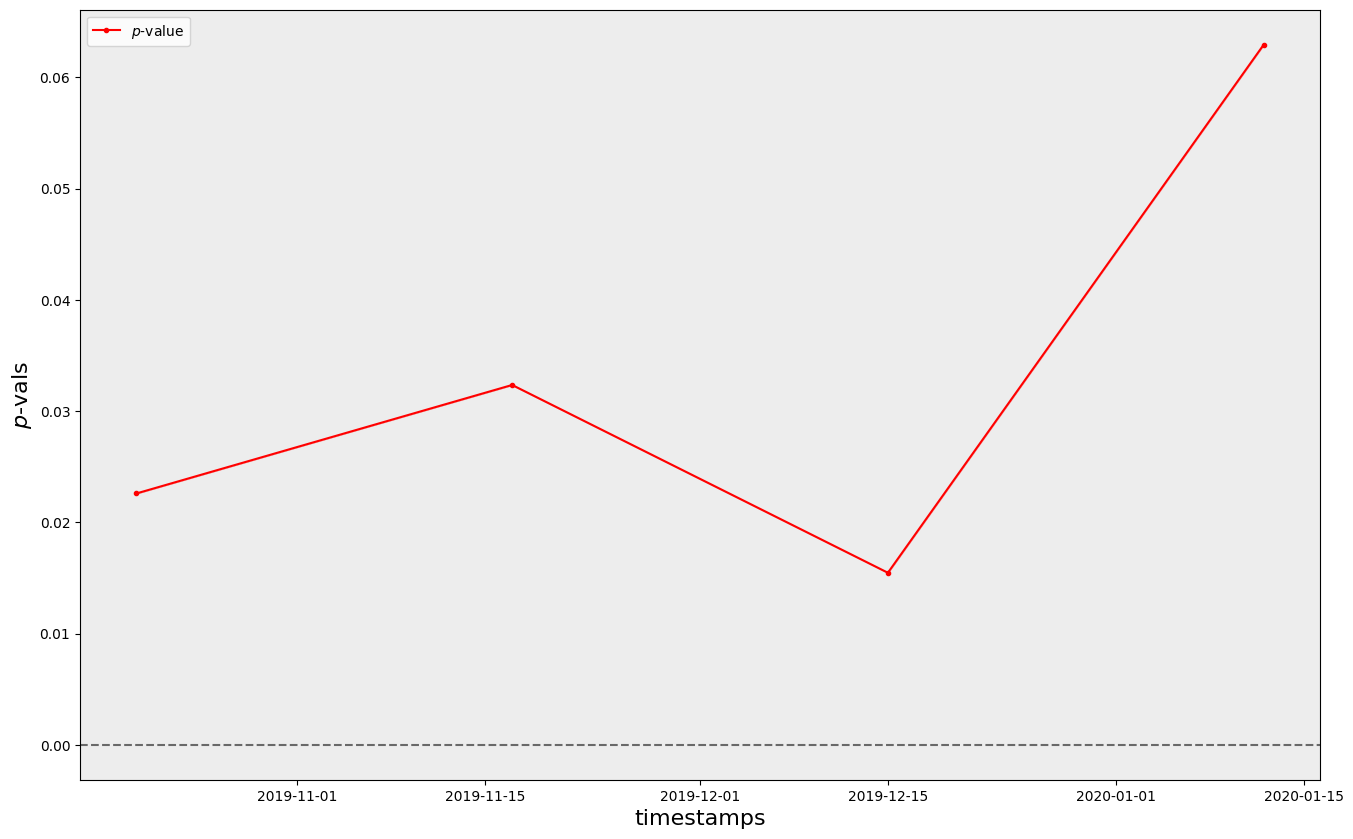

In [6]:
model = DenseNet(weights="densenet121-res224-all")
detector = Detector(
    "rolling_window_drift",
    reductor=Reductor(
        dr_method="bbse-soft",
        model=model,
        transforms=transforms,
        feature_columns=["image"],
    ),
    tester=TSTester(tester_method="ks"),
    source_sample_size=50,
    target_sample_size=10,
    timestamp_column="timestamp",
    window_size="4W",
)

results = detector.detect_shift(source_ds, target_ds)
plot_drift_timeseries(results)